# Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# SIFT Algorithm

In [10]:
def SIFT(img):

    img_gray = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    keypoints = sift.detect(img_gray, None)
    img_sift = cv2.drawKeypoints(img_gray, keypoints, img_gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure()
    plt.imshow(img_sift)
    plt.show()

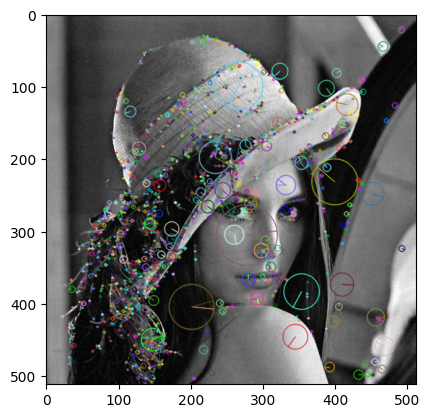

In [11]:
SIFT('lena.png')

# SURF Algorithm

In [2]:
def box_filter(image, size):
    return cv2.boxFilter(image, ddepth=-1, ksize=(size, size))

def hessian_matrix(image, sigma):
    Ixx = gaussian_filter(image, sigma=sigma, order=(2, 0))
    Iyy = gaussian_filter(image, sigma=sigma, order=(0, 2))
    Ixy = gaussian_filter(image, sigma=sigma, order=(1, 1))
    return Ixx, Iyy, Ixy

def determinant_hessian(Ixx, Iyy, Ixy):
    return (Ixx * Iyy) - (Ixy ** 2)

def non_max_suppression(dog, threshold=0.01):
    keypoints = []
    for i in range(1, dog.shape[0] - 1):
        for j in range(1, dog.shape[1] - 1):
            region = dog[i-1:i+2, j-1:j+2]
            if dog[i, j] == np.max(region) and dog[i, j] > threshold:
                keypoints.append((i, j))
    return keypoints

def assign_orientation(image, keypoints):
    orientations = []
    for kp in keypoints:
        y, x = kp
        wavelet_x = gaussian_filter(image, sigma=1, order=(1, 0))[y, x]
        wavelet_y = gaussian_filter(image, sigma=1, order=(0, 1))[y, x]
        orientation = np.arctan2(wavelet_y, wavelet_x)
        orientations.append(orientation)
    return orientations

def get_descriptor(image, keypoints, orientations):
    descriptors = []
    for kp, ori in zip(keypoints, orientations):
        y, x = kp
        patch = image[y-8:y+8, x-8:x+8]
        patch = gaussian_filter(patch, sigma=1)
        dx = gaussian_filter(patch, sigma=1, order=(1, 0))
        dy = gaussian_filter(patch, sigma=1, order=(0, 1))
        magnitude = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx)
        descriptor = np.histogram(angle, bins=8, weights=magnitude)[0]
        descriptors.append(descriptor)
    return np.array(descriptors)

def plot_keypoints_matplotlib(image, keypoints):

    cv2_keypoints = [cv2.KeyPoint(float(x[1]), float(x[0]), 1) for x in keypoints]
    
    image_with_keypoints = cv2.drawKeypoints(image, cv2_keypoints, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    image_with_keypoints_rgb = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_keypoints_rgb)
    plt.axis('off')  
    plt.show()

def surf(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    Ixx, Iyy, Ixy = hessian_matrix(gray, sigma=1.5)
    det_hessian = determinant_hessian(Ixx, Iyy, Ixy)
    
    keypoints = non_max_suppression(det_hessian, threshold=0.01)
    orientations = assign_orientation(gray, keypoints)
    descriptors = get_descriptor(gray, keypoints, orientations)
    
    plot_keypoints_matplotlib(image, keypoints)
    
    return keypoints, descriptors

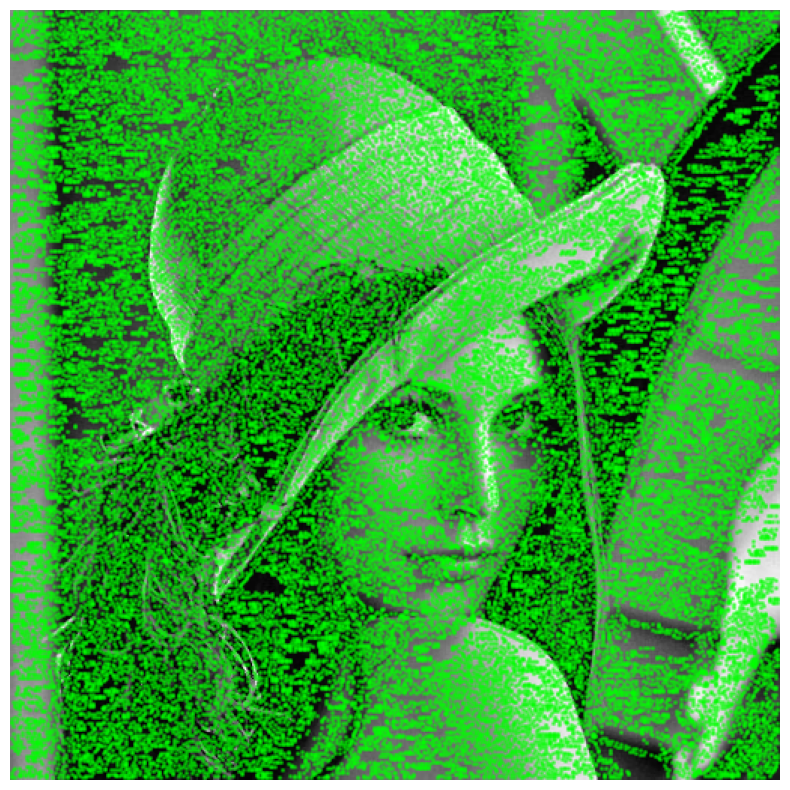

In [3]:
image = cv2.imread('lena.png') 
keypoints, descriptors = surf(image)